普通のDNNでwightが直交行列になるかをconditional numberを用いて観察する。

In [2]:
from __future__ import division

import time
import gzip

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

import TN_utils
reload(TN_utils)
plt.set_cmap("gray")
plt.rcParams["image.interpolation"] = None

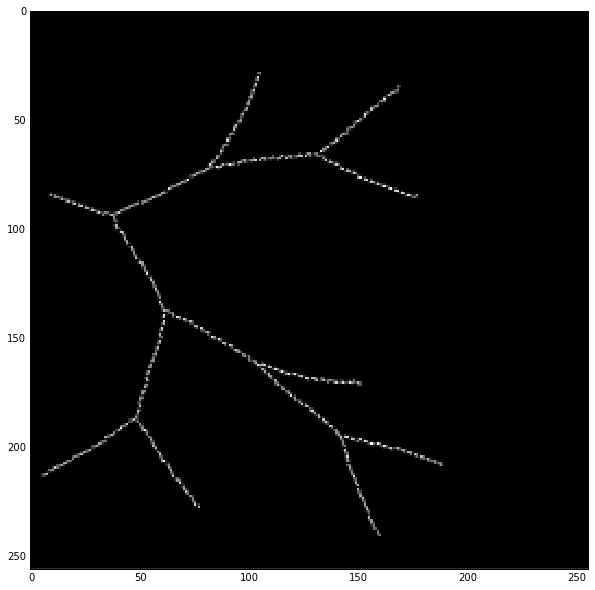

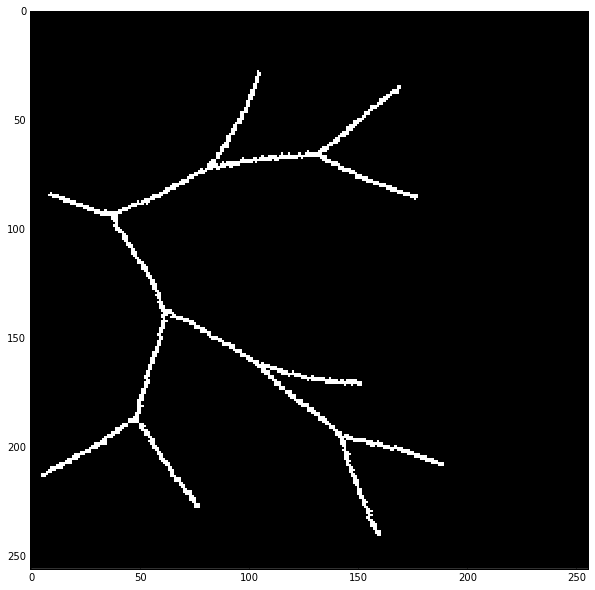

In [3]:
with gzip.open("../data/toytreerot_imgGT.npy.gz") as f:
    imGT_list = np.load(f)
imGT_list.shape
plt.figure(figsize=(10, 10))
plt.imshow(np.linalg.norm(imGT_list[6], axis=1).reshape(256, 256))
for i in range(len(imGT_list)):
    index = np.linalg.norm(imGT_list[i], axis=1).nonzero()[0]
    imGT_list[i][index] = imGT_list[i][index] / np.linalg.norm(imGT_list[i], axis=1)[index][:, np.newaxis]
plt.figure(figsize=(10, 10))
plt.imshow(np.linalg.norm(imGT_list[6], axis=1).reshape(256, 256))

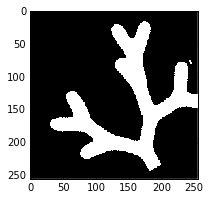

In [4]:
with gzip.open("../data/toytreerot_mask.npy.gz") as f:
    mask_list = np.load(f)
mask_list.shape
plt.figure(figsize=(3, 3))
plt.imshow(mask_list[20].reshape(256, 256))

In [5]:
featureImg_list = []
for i in range(1, 37):
    print i
    matlab_struct = sio.loadmat('../data/featureImgr' + str(i) + '.mat')
    featureImg = matlab_struct['f']

    # 複素数からベクトルへの変換
    featureImg_vec = np.zeros((featureImg.shape[0], 12, 2))
    featureImg_vec[:, :, 0] = np.real(featureImg[:, 12:24])
    featureImg_vec[:,:,1] = np.imag(featureImg[:, 12:24])
    featureImg_list.append(featureImg_vec)

print featureImg.dtype, featureImg_list[1].shape

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
complex128 (65536, 12, 2)


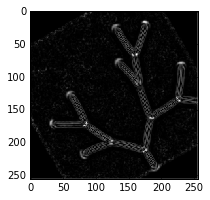

In [6]:
plt.figure(figsize=(3, 3))
plt.imshow(np.linalg.norm(featureImg_list[20][:, 5], axis=1).reshape(256, 256))

In [7]:
m_featureImg_list = [featureImg_list[i][mask_list[i]] for i in range(36)]
m_imgGT_list = [imGT_list[i][mask_list[i]] for i in range(36)]

In [8]:
m_feature_t1 = m_featureImg_list[35]
m_GT_t1 = m_imgGT_list[35]
m_feature_t1.shape, m_GT_t1.shape

((14138, 12, 2), (14138, 2))

In [9]:
range(0, 36, 3)

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33]

In [10]:
# 10, 40, 70, 130, ...340の12サンプル
m_feature_t12 = np.concatenate([m_featureImg_list[i] for i in range(0, 36, 3)], axis=0)
m_GT_t12 = np.concatenate([m_imgGT_list[i] for i in range(0, 36, 3)], axis=0)
print m_feature_t12.shape, m_GT_t12.shape

(166492, 12, 2) (166492, 2)


In [11]:
m_feature_t36 = np.concatenate([m_featureImg_list[i] for i in range(0, 11) + range(12, 36)], axis=0)
m_GT_t36 = np.concatenate([m_imgGT_list[i] for i in range(0, 11) + range(12, 36)], axis=0)
print m_feature_t36.shape, m_GT_t36.shape

(485423, 12, 2) (485423, 2)


In [12]:
m_feature_vec120 = m_featureImg_list[11]
m_GT_vec120 = m_imgGT_list[11]

In [13]:
activation_list = ["ReLU", "ReLU"]
n_tensors = 12
dim = 2
n_hidden = 4
param_list = [0.01 * np.random.normal(size=(n_tensors*dim, n_hidden)), np.zeros(n_hidden),
              0.01 * np.random.normal(size=(n_hidden, dim)), np.zeros(dim)]

In [14]:
import theano_dnn
reload(theano_dnn)

Couldn't import dot_parser, loading of dot files will not be possible.


<module 'theano_dnn' from 'theano_dnn.pyc'>

In [16]:
theano_dnn.VnnClf?

In [17]:
vnn = theano_dnn.VnnClf(m_feature_t1, m_GT_t1,
                         m_feature_vec120, m_GT_vec120,
                         param_list, ["w1", "b1", "w2", "b2"],
                        activation_list,
                       [2, 2])

In [18]:
vnn.initialize_params(param_list)

In [21]:

vnn.set_training(feature_list[1], GT_list[1]) 

In [22]:
batch_size = 100
l2 = 0.

n_batchs = vnn.n_pixels // batch_size
        
n_epochs = epoch_list[1]
interval = n_epochs // 30
training_MSE_array = np.zeros(n_epochs // interval)
test_MSE_array = np.zeros(n_epochs // interval)

In [23]:
cn_list_list = []
weighted_sum_list = []
lr = lr_list[1]
for i_epoch in xrange(n_epochs):
    for i_batch in xrange(n_batchs):
        vnn.train(i_batch, lr, l2, batch_size)

    if i_epoch % interval == 0:
        MSE = vnn.training_error()
        training_MSE_array[i_epoch // interval] = MSE
        MSE = vnn.test_error()
        test_MSE_array[i_epoch // interval] = MSE

        w_list = vnn.get_w_list()
        cn_list = []
        for aw in w_list:
            cn_list.append(TN_utils.clcl_cn_inv(aw))
        cn_list_list.append(cn_list)
        w_norm_list = np.asarray([np.sum(w**2) for w in w_list])
        weighted_sum = np.sum(np.asarray(cn_list) * np.asarray(w_norm_list))
        n_weighted_sum = weighted_sum / np.sum(w_norm_list)
        weighted_sum_list.append(n_weighted_sum)

        print i_epoch, MSE

0 0.0383256879344
6 0.0138914436176
12 0.0138461674745
18 0.0138283366968
24 0.0138192436152
30 0.0138147751436
36 0.0138128425963
42 0.0138122508527
48 0.0138123184766
54 0.0138126693613
60 0.0138131059539
66 0.0138135320018
72 0.0138139065524
78 0.0138142173582
84 0.013814465997
90 0.013814659855
96 0.0138148080166
102 0.0138149193074
108 0.0138150014837
114 0.0138150610034
120 0.0138151030699
126 0.0138151317882
132 0.013815150351
138 0.0138151612172
144 0.0138151662674
150 0.0138151669333
156 0.0138151643006
162 0.0138151591911
168 0.0138151522257
174 0.0138151438726


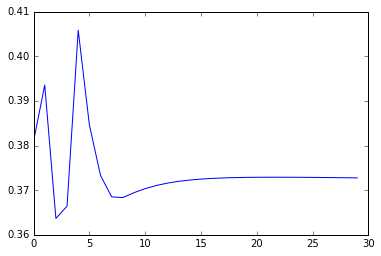

In [24]:
plt.plot(np.mean(cn_list_list, axis=1))

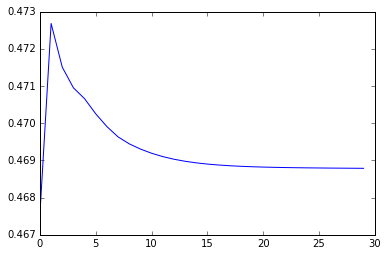

In [25]:
# まじか
plt.plot(weighted_sum_list)

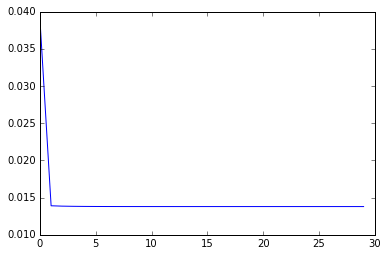

In [26]:
plt.plot(training_MSE_array)

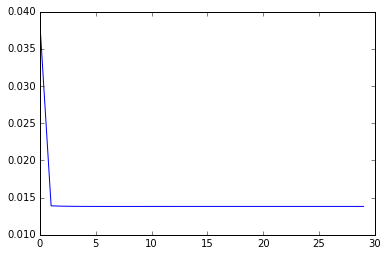

In [27]:
plt.plot(test_MSE_array)

In [28]:
import cond_num_dnn_ex
reload(cond_num_dnn_ex)

<module 'cond_num_dnn_ex' from 'cond_num_dnn_ex.pyc'>

In [31]:
feature_list =[m_feature_t1, m_feature_t12, m_feature_t36]
GT_list = [m_GT_t1, m_GT_t12, m_GT_t36]
epoch_list = [2160, 180, 60]
lr_list = [0.0005, 0.0005, 0.0005]

In [32]:
results = cond_num_dnn_ex.cond_num_dnn_ex(vnn, param_list, feature_list, GT_list, 
                                          lr_list, epoch_list, featureImg_list)

0 0.0527677639831
144 0.0442759810421
288 0.0248505585742
432 0.0189634291971
576 0.0179041125792
720 0.0176998815786
864 0.0176388701845
1008 0.0176086291837
1152 0.017588182731
1296 0.0175723431809
1440 0.017559262898
1584 0.0175480500938
1728 0.0175381928856
1872 0.0175293701281
2016 0.0175213692059
0 0.0525242799341
12 0.0291443402926
24 0.0147336654005
36 0.013996326429
48 0.0139227931568
60 0.0138891251965
72 0.0138692304759
84 0.0138560123908
96 0.0138463919669
108 0.0138388884091
120 0.0138327508846
132 0.0138275767202
144 0.0138231344279
156 0.0138192797732
168 0.0138159151341
0 0.0518781976836
4 0.0272677804329
8 0.0150495905085
12 0.0142163741843
16 0.0141268692217
20 0.0140900287504
24 0.0140675950245
28 0.0140519979761
32 0.0140402267345
36 0.0140307937293
40 0.0140229086765
44 0.0140161296196
48 0.0140101950421
52 0.0140049398529
56 0.0140002524342


In [39]:
train_error_list, test_error_list, cn11236, wsc11236, gt1img360_list, gt1img120_list = results

In [40]:
namelist = ["train_error_list", "test_error_list", "cn11236", "wsc11236", "gt1img360_list", "gt1img120_list"]
for data, name in zip(results, namelist):
    with gzip.open("../results/CondNumDNNnh4/"+name+".npy.gz", "w") as f:
        np.save(f, data)

In [41]:
sio.savemat('../results/CondNumDNNnh4/v_train360_list.mat', {'v_train360_list': gt1img360_list})
sio.savemat('../results/CondNumDNN/v_train120_list.mat', {'v_train120_list': gt1img120_list})

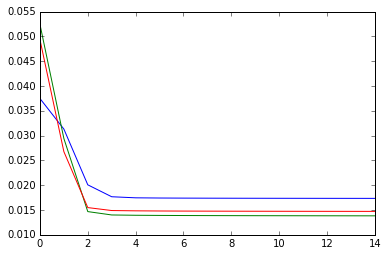

In [42]:
for i in range(3):    
    plt.plot(train_error_list[i])

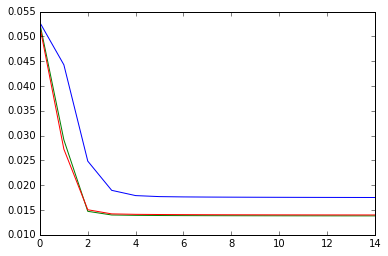

In [43]:
for i in range(3): 
    plt.plot(test_error_list[i])

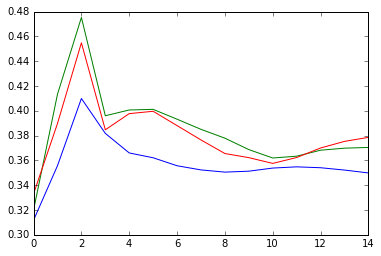

In [44]:
for i in range(3):
    plt.plot(np.mean(cn11236[i], axis=1))

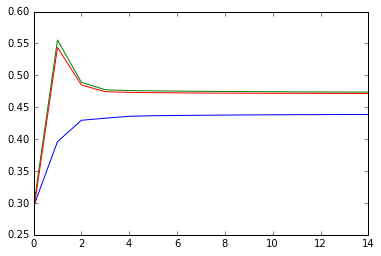

In [45]:
for i in range(3):    
    plt.plot(wsc11236[i])

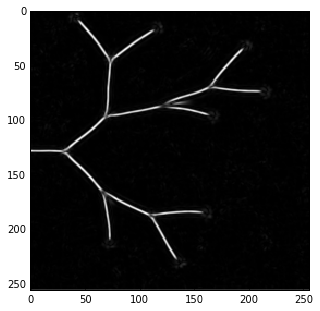

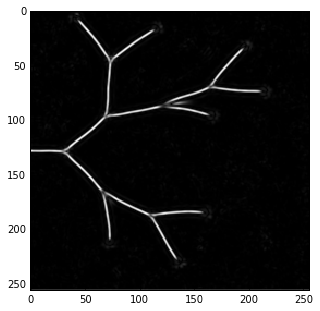

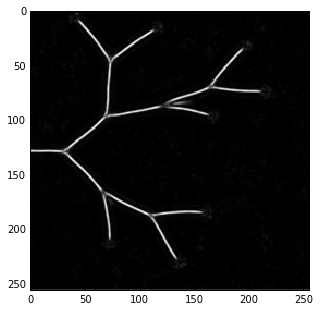

In [46]:
for i in range(3):
    plt.figure(figsize=(5, 5))
    plt.imshow(np.linalg.norm(gt1img360_list[i], axis=0))

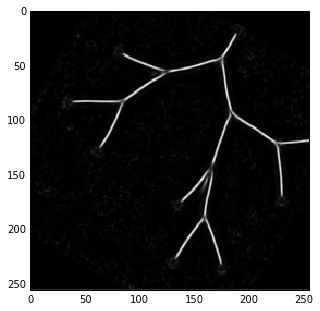

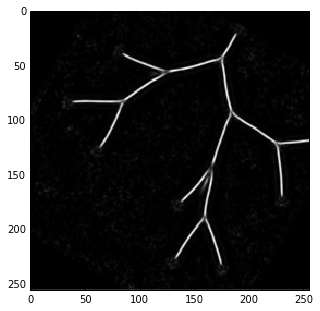

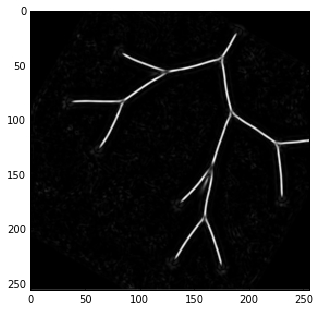

In [47]:
for i in range(3):
    plt.figure(figsize=(5, 5))
    plt.imshow(np.linalg.norm(gt1img120_list[i], axis=0))